<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019-06-23-LSTM_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12C%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20LSTMs.ipynb



Making the following changes:

* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification
* running fit with 50 epochs with early stopping with patience of 2

In [1]:
# attach google drive to access data files and to save models and reports
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import LSTM
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt
import logging


%matplotlib inline
sns.set()

# import custom utilities
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku


logging.basicConfig(level=logging.INFO)


Using TensorFlow backend.


In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
# keep words under this qunatile length as features
QUANTILE = 0.99

In [4]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# df = pd.read_csv(f"{DATA_DIR}/{DATA_FILE}")
df = pd.read_csv(f"{DATA_FILE}")

In [6]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date
0,48623501,R1G7J2VAMI4AEC,B00LBK7QBY,361030039,universal waterproof case joto cellphone dry b...,Wireless,5,0,0,good product please note not,good product please note not floating case do ...,2015-08-31
1,533148,R3Q4JAPXWCCJU7,B00W661MOO,360205932,car mount alpatronix mx101 universal charging ...,Wireless,5,0,0,great product holds phone place,great product holds phone place does not slip ...,2015-08-31
2,40266813,RJQWVO0QV2WQ4,B00USN9L0E,105913119,synthetic leather galaxy s6 sleeve thin,Wireless,5,0,0,exactly described,quality looks good prompt postage cannot argue...,2015-08-31
3,228806,R3RFPR7X60WN6C,B00YPAOKMU,564491128,jiake s6 5 0 inch unlocked smart phone quad co...,Wireless,5,0,0,powerful attractive really do love mode,works much like jiake phone love price great b...,2015-08-31
4,10866798,R3QL2UPH2B7YFT,B00O0S97SE,742788022,tfy universal car headrest mount holder portab...,Wireless,3,0,1,good enough,serves purpose loud whoever sitting seat attached,2015-08-31


In [0]:
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

**Preprocessing**

In [8]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(112043,)
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [0]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)

In [0]:
train_sequences = t.texts_to_sequences(reviews_train)

In [12]:
train_sequences[:2]

[[20,
  24,
  16,
  11,
  1,
  21,
  2629,
  398,
  710,
  67,
  341,
  30,
  2290,
  153,
  140,
  13,
  1,
  28,
  186,
  396,
  20,
  16,
  93,
  370,
  1346,
  408,
  992],
 [99, 70, 31, 1, 168, 44, 1744, 452]]

In [0]:
# from collections import Counter

# tokenized_train = [tn.tokenizer.tokenize(text) for text in reviews_train]
# tokenized_test = [tn.tokenizer.tokenize(text) for text in reviews_test]

# # build word to index vocabulary
# token_counter = Counter([token for review in tokenized_train for token in review])
# vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
# max_index = np.max(list(vocab_map.values()))
# vocab_map['PAD_INDEX'] = 0
# vocab_map['NOT_FOUND_INDEX'] = max_index+1
# vocab_size = len(vocab_map)
# # view vocabulary size and part of the vocabulary map
# print('Vocabulary Size:', vocab_size)
# print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

# max_len = np.max([len(review) for review in tokenized_train])

# ## Train reviews data corpus
# # Convert tokenized text reviews to numeric vectors
# train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
# train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 

# ## Test reviews data corpus
# # Convert tokenized text reviews to numeric vectors
# test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
#            for token in tokenized_review] 
#               for tokenized_review in tokenized_test]
# test_X = sequence.pad_sequences(test_X, maxlen=max_len)

# # view vector shapes
# print('Max length of train review vectors:', max_len)
# print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

In [14]:
test_sequences = t.texts_to_sequences(reviews_test)
test_sequences[:2]

[[9,
  608,
  2584,
  670,
  437,
  246,
  2,
  323,
  5,
  31,
  203,
  340,
  1414,
  643,
  342,
  147,
  242,
  272,
  54,
  128,
  278,
  908,
  27],
 [764,
  1621,
  4,
  783,
  2,
  11,
  1,
  149,
  260,
  3,
  914,
  243,
  249,
  2369,
  2,
  9,
  105,
  11,
  3,
  131,
  94,
  128,
  10,
  21]]

In [15]:
print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


Vocabulary size=40788
Number of Documents=84032


**Sequence Normalization**

Figure out max length of review and pad the rest so they are all the same length

In [16]:
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
df.review_length.max()

2864

In [17]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_length
count,1.120430e+05,1.120430e+05,112043.000000,112043.000000,112043.000000,112043.000000
mean,2.547598e+07,4.994998e+08,3.889078,0.912435,1.189704,26.322965
std,1.582173e+07,2.879968e+08,1.463196,10.304687,11.167197,47.248166
min,1.014100e+04,1.365700e+04,1.000000,0.000000,0.000000,1.000000
25%,1.231110e+07,2.493906e+08,3.000000,0.000000,0.000000,8.000000
50%,2.344848e+07,4.990693e+08,5.000000,0.000000,0.000000,15.000000
75%,4.040851e+07,7.481358e+08,5.000000,0.000000,1.000000,29.000000
max,5.309655e+07,9.999930e+08,5.000000,1447.000000,1524.000000,2864.000000


In [18]:
df.review_length.quantile([0.95, 0.96, 0.97, 0.98, 0.99])

0.95     84.0
0.96     95.0
0.97    110.0
0.98    136.0
0.99    186.0
Name: review_length, dtype: float64

In [19]:
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([QUANTILE]).values[0])
MAX_SEQUENCE_LENGTH

186

Looks like 99% of our reviews have 186 words or less. If we keep our sequence length to around 186 words, this should allow us to keep most of our content

NOTE: no need to do encoding for our star_ratings since this is already in a number format

In [0]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [21]:
X_train[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [22]:
print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)

Train review vectors shape: (84032, 186)  Test review vectors shape: (28011, 186)


In [23]:
rating.head()

0    5
1    5
2    5
3    5
4    3
Name: star_rating, dtype: int64

In [0]:
MODEL_NAME = "LSTM_1layer"
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1
LSTM_DIM = 64 # total LSTM units



**Build LSTM Model Architecture**

In [25]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

W0729 20:40:20.014733 140027162118016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 20:40:20.022660 140027162118016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 20:40:20.028646 140027162118016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 20:40:20.065310 140027162118016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0729 20:40:20.077247 

In [26]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 186, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 12,330,465
Trainable params: 12,330,465
Non-trainable params: 0
_________________________________________________________________
None


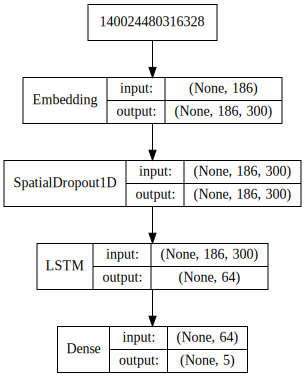

In [27]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

In [29]:
# wrap the model in our object to make reporting and metrics gathering easier
mw = ku.ModelWrapper(name=MODEL_NAME, 
                     label_name=LABEL_COLUMN, 
                     model=model, 
                     data_file=DATA_FILE, 
                     embedding=EMBED_SIZE,
                     tokenizer=t)
network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0729 20:40:21.018197 140027162118016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 238s 4ms/step - loss: 0.9649 - acc: 0.6319 - val_loss: 0.8783 - val_acc: 0.6569
Epoch 2/50
67225/67225 [==============================] - 237s 4ms/step - loss: 0.7983 - acc: 0.6892 - val_loss: 0.8629 - val_acc: 0.6646
Epoch 3/50
67225/67225 [==============================] - 239s 4ms/step - loss: 0.7227 - acc: 0.7212 - val_loss: 0.8829 - val_acc: 0.6579
Epoch 4/50
67225/67225 [==============================] - 238s 4ms/step - loss: 0.6565 - acc: 0.7518 - val_loss: 0.9088 - val_acc: 0.6584
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


In [30]:
mw.evaluate(X_test, y_test)


Running model.evaluate...
28011/28011 [==============================] - 133s 5ms/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...


In [31]:
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

Accuracy: 67.14%


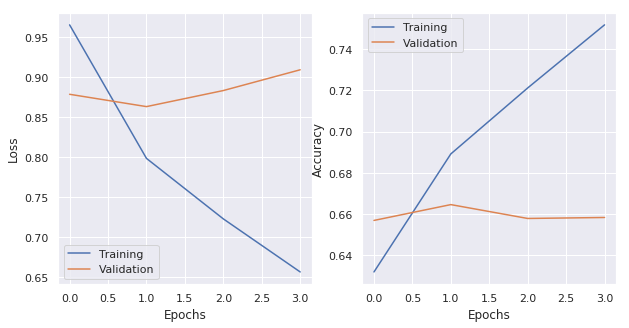

In [32]:
pu.plot_network_history(mw.network_history)

In [33]:
print(mw.confusion_matrix)

[[ 3292   151   185    41   299]
 [  985   204   271   114   297]
 [  654   213   596   398   670]
 [  245    89   410   985  3023]
 [  306    32   225   597 13729]]


In [34]:
print(mw.classification_report)

              precision    recall  f1-score   support

           1       0.60      0.83      0.70      3968
           2       0.30      0.11      0.16      1871
           3       0.35      0.24      0.28      2531
           4       0.46      0.21      0.29      4752
           5       0.76      0.92      0.83     14889

    accuracy                           0.67     28011
   macro avg       0.49      0.46      0.45     28011
weighted avg       0.62      0.67      0.63     28011



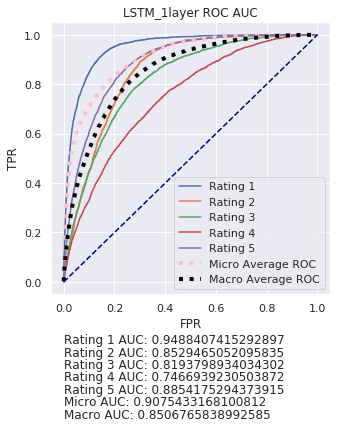

In [35]:
fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(MODEL_NAME, mw.roc_auc, mw.fpr, mw.tpr)

**Save off various files**

In [0]:
# _, inbasename = fu.get_dir_basename(mw.data_file)
mw.save(DRIVE_DIR, append_report=True)

In [37]:
mw.get_report().to_df()

,accuracy,classification_report,confusion_matrix,description,embedding,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features
0,0.671379,"{""1"": {""precision"": 0.6005107624954397, ""recal...","[[3292, 151, 185, 41, 299], [985, 204, 271, 11...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.852547,186.0,drive/My Drive/Springboard/capstone/models/ama...,LSTM_1layer,<keras.callbacks.History object at 0x7f59f979f...,"{""auc_1"": 0.9488407415292897, ""auc_2"": 0.85294...",success,2019-07-29 21:00:49,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.01033266...",84032.0,186.0


In [0]:
# _, INBASENAME = fu.get_dir_basename(DATA_FILE)
# DESCRIPTION = f"{INBASENAME}-{MODEL_NAME}-{MAX_SEQUENCE_LENGTH}-{LABEL_COLUMN}"
# MODEL_FILE = f"{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
# NETWORK_HISTORY_FILE = f'{DRIVE_DIR}/models/{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
# REPORT_FILE = f"{DRIVE_DIR}/reports/{datetime.now().strftime(DATE_FORMAT)}-DNN_protype-report.csv"
# TOKENIZER_FILE = f'{DRIVE_DIR}/models/dl-tokenizer.pkl'


In [0]:
# model.save(MODEL_FILE)

In [0]:
# pickle.dump(mw.network_history, open(NETWORK_HISTORY_FILE, "wb"))

In [0]:
# pickle.dump(mw.tokenizer, open(TOKENIZER_FILE, "wb"))

In [0]:
# model_report = mw.get_report()
# model_report
